# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [718]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [719]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [720]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [721]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [722]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X_orig,y = load_data(dirpath)
X = X_orig
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

dirpath2 = './dataset/Yale_face_database/'
X2_orig,y2 = load_data(dirpath2)
X2 = X2_orig
N2,H2,W2 = X2.shape[0:3]
C2 = 1 if opt['is_grayscale'] else X2.shape[3]

dirpath3 = './dataset/IIIT-CFW/'
X3_orig,y3 = load_data(dirpath3)
X3 = X3_orig
N3,H3,W3 = X3.shape[0:3]
C3 = 1 if opt['is_grayscale'] else X3.shape[3]

Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)


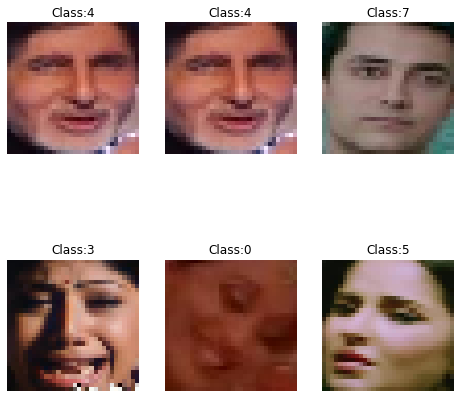

In [723]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

In [724]:
X.shape

(400, 32, 32, 3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [725]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

In [726]:
# Flatten to apply PCA/LDA
X2 = X2.reshape((N2,H2*W2*C2))
# Flatten to apply PCA/LDA
X3 = X3.reshape((N3,H3*W3*C3))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [727]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k,pca

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [728]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k,kpca

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [729]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k,lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [730]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k,klda

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [731]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [732]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of human face recognition. It is a method that is useful for face recognition and detection by determining the variance of faces in a collection of face images and use those variances to encode and decode a face in a machine learning way without the full information reducing computation and space complexity. In dimensionality reduction techniques like PCA, eigenfaces are essentially the principal components that can properly describe the image that maximizes the variance between them and minimizes reconstruction error.

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [733]:
X3.shape

(672, 3072)

In [734]:
# Compute your features 
# eg.
X_3D,_ = get_kernel_lda(X,y,3)
X2_3D,_ = get_kernel_lda(X2,y2,3)
X3_3D,_ = get_kernel_lda(X3,y3,3)

/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Text(0.5, 0.92, 'IIIT cartoon face dataset')

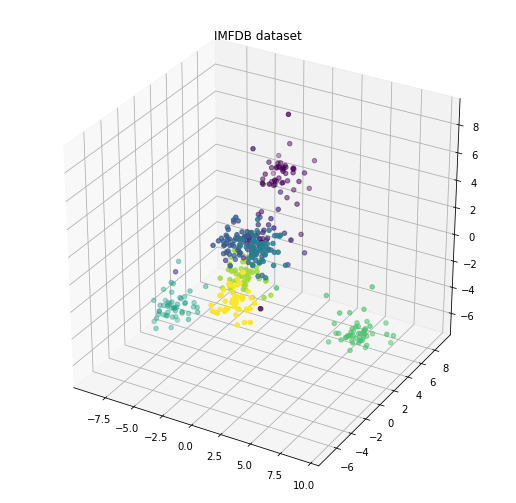

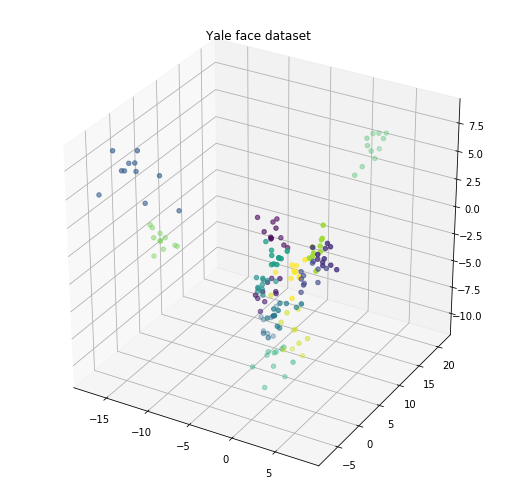

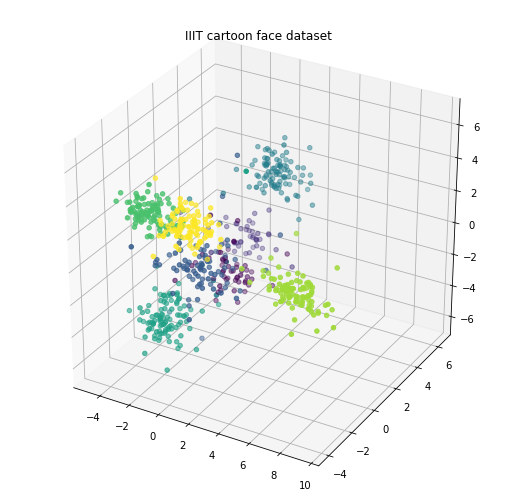

In [735]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
plt.title("IMFDB dataset")

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2_3D[:,0],X2_3D[:,1],X2_3D[:,2],c=y2)
plt.title("Yale face dataset")

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3_3D[:,0],X3_3D[:,1],X3_3D[:,2],c=y3)
plt.title("IIIT cartoon face dataset")


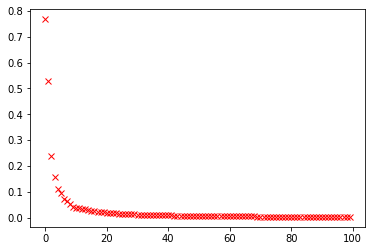

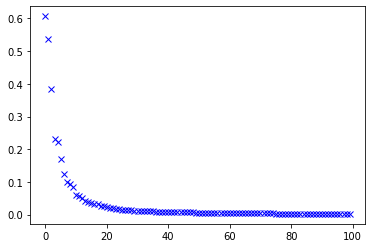

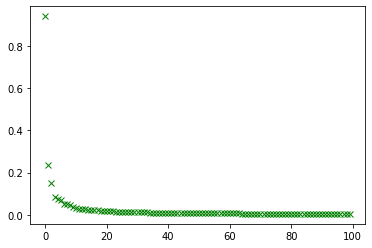

In [736]:
# Plot the eigen value spectrum 
from numpy import linalg as LA
train_data = X
cov_total = np.cov(train_data, rowvar=False)
eigval, eigvec = LA.eig(cov_total)
norm_eig = eigval.real/LA.norm(eigval)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(norm_eig[0:100],'rx')

train_data = X2
cov_total = np.cov(train_data, rowvar=False)
eigval, eigvec = LA.eig(cov_total)
norm_eig = eigval.real/LA.norm(eigval)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(norm_eig[0:100],'bx')
# plt.plot(norm_eig[0:100],'bx')

train_data = X3
cov_total = np.cov(train_data, rowvar=False)
eigval, eigvec = LA.eig(cov_total)
norm_eig = eigval.real/LA.norm(eigval)
# plt.plot(norm_eig[0:100],'gx')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(norm_eig[0:100],'gx')

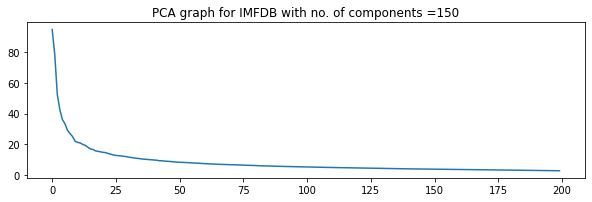

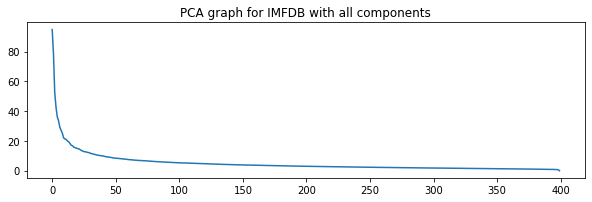

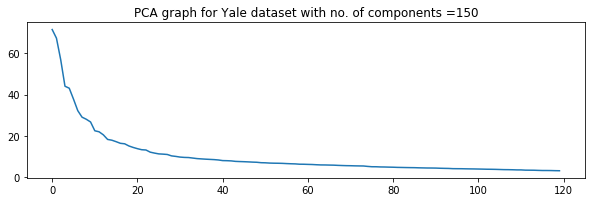

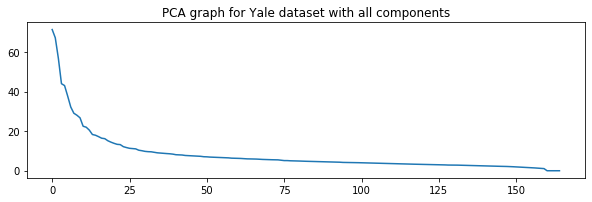

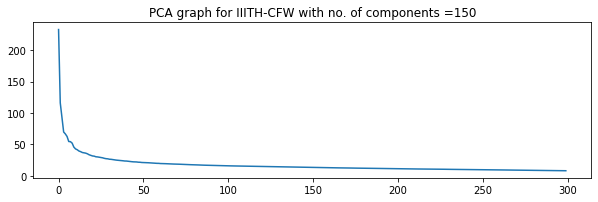

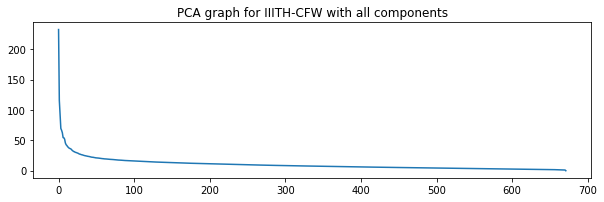

In [737]:
#do PCA for all 3 datasets

def showgraphs(pca,i,title):
    eig1 = pca.singular_values_
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(int("61"+str(i)))
    ax.plot(eig1)
    plt.title(title)
    
comp = 150
_,pca = get_pca(X,200)
showgraphs(pca,1,"PCA graph for IMFDB with no. of components =" + str(comp))
_,pca = get_pca(X,len(X))
showgraphs(pca,2,"PCA graph for IMFDB with all components")
_,pca = get_pca(X2,120)
showgraphs(pca,3,"PCA graph for Yale dataset with no. of components =" + str(comp))
_,pca = get_pca(X2,len(X2))
showgraphs(pca,4,"PCA graph for Yale dataset with all components")
_,pca = get_pca(X3,300)
showgraphs(pca,5,"PCA graph for IIITH-CFW with no. of components =" + str(comp))
_,pca = get_pca(X3,len(X3))
showgraphs(pca,6,"PCA graph for IIITH-CFW with all components")



/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/kernel_pca.py:304: RuntimeWarning: invalid value encountered in sqrt
  X_transformed = self.alphas_ * np.sqrt(self.lambdas_)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/kernel_pca.py:304: RuntimeWarning: invalid value encountered in sqrt
  X_transformed = self.alphas_ * np.sqrt(self.lambdas_)


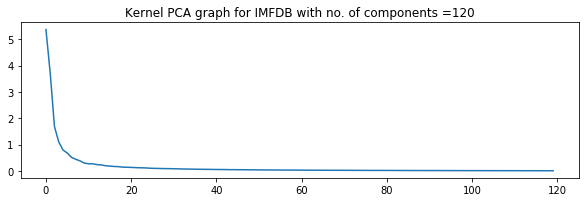

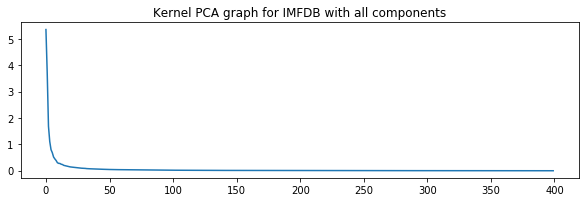

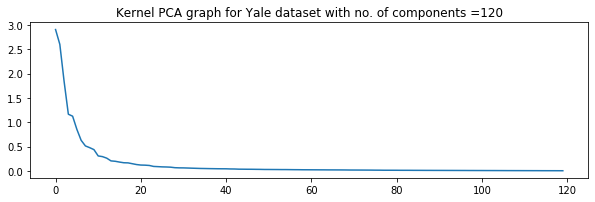

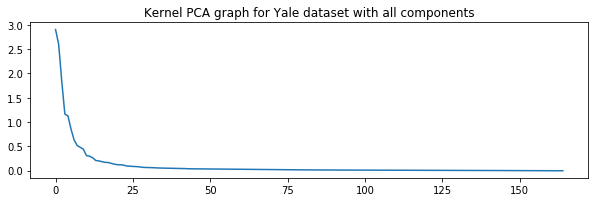

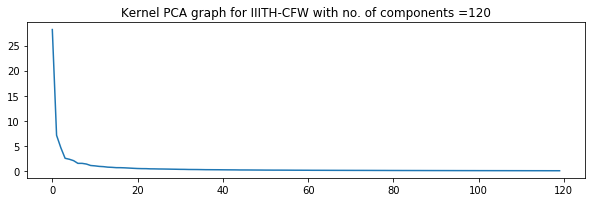

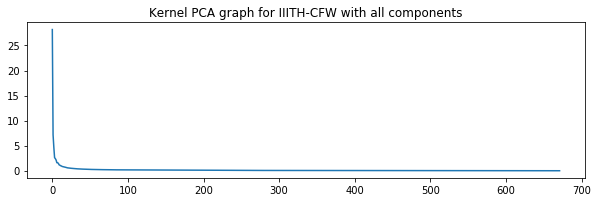

In [738]:
#do kernel PCA for all 3 datasets

def showgraphs(pca,i,title):
    eig1 = pca.lambdas_
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(int("61"+str(i)))
    ax.plot(eig1)
    plt.title(title)
    
comp = 120
_,pca = get_kernel_pca(X,comp)
showgraphs(pca,1,"Kernel PCA graph for IMFDB with no. of components =" + str(comp))
_,pca = get_kernel_pca(X,len(X))
showgraphs(pca,2,"Kernel PCA graph for IMFDB with all components")
_,pca = get_kernel_pca(X2,comp)
showgraphs(pca,3,"Kernel PCA graph for Yale dataset with no. of components =" + str(comp))
_,pca = get_kernel_pca(X2,len(X2))
showgraphs(pca,4,"Kernel PCA graph for Yale dataset with all components")
_,pca = get_kernel_pca(X3,comp)
showgraphs(pca,5,"Kernel PCA graph for IIITH-CFW with no. of components =" + str(comp))
_,pca = get_kernel_pca(X3,len(X3))
showgraphs(pca,6,"Kernel PCA graph for IIITH-CFW with all components")



1(c). Reconstruct  the  image  back for each case


In [739]:
def reconstruct_images(eig,pca,dims):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    N,H,W,C = dims[0],dims[1],dims[2],dims[3]
    reconstruct_X = pca.inverse_transform(eig)
#     print (reconstruct_X.shape)
    reconstruct_X = reconstruct_X.reshape((N,H,W,C))
#     print (reconstruct_X.shape)
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


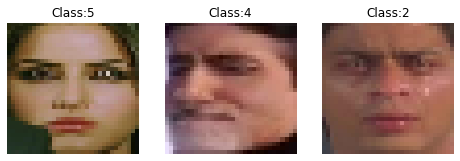

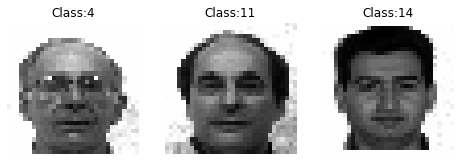

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


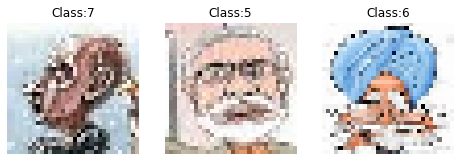

In [740]:
# Display results 
def func(X):
    N,H,W,C = X.shape
    X=X.reshape((N,H*W*C))
    return X

pca1 = PCA()
X=func(X_orig)
p1 = pca1.fit(X).transform(X)  

pca2 = PCA()
X=func(X2_orig)
p2 = pca2.fit(X).transform(X) 

pca3 = PCA()
X=func(X3_orig)
p3 = pca3.fit(X3).transform(X3)

eiglist = [p1,p2,p3]
pcalist = [pca1,pca2,pca3]
orglist = [X_orig,X2_orig,X3_orig]
ys = [y,y2,y3]
for i in range(len(eiglist)):
    X_reconstructed = reconstruct_images(eiglist[i], pcalist[i], list(orglist[i].shape))

    #Display random images
    ind = np.random.randint(0,ys[i].shape[0],3)
    try:
        disply_images(X_reconstructed[ind,...],ys[i][ind],row=1,col=3)
    except:
        pass        

In [741]:
#normal LDA
def ldastuff(X,y):
    N,H,W,C = X.shape
    X=X.reshape((N,H*W*C))    
    _,lda = get_lda(X,y,k=None) 
    sv = np.sort(lda.explained_variance_ratio_)
    sv = sv[::-1]
    sum_sv = 0
    for ev in range(len(sv)):
        if sum_sv <= 0.9*np.sum(sv):
            sum_sv += sv[ev] 
        else:
            break
    return ev

imfdb_lda_ev = ldastuff(X_orig,y)
yale_lda_ev = ldastuff(X2_orig,y2)
iiit_lda_ev = ldastuff(X3_orig,y3)

#kernel LDA

def kldastuff(X,y):
    N,H,W,C = X.shape
    X=X.reshape((N,H*W*C))    
    _,klda = get_kernel_lda(X,y,k=None) 
    sv = np.sort(klda.explained_variance_ratio_)
    sv = sv[::-1]
    sum_sv = 0
    for ev in range(len(sv)):
        if sum_sv <= 0.9*np.sum(sv):
            sum_sv += sv[ev] 
        else:
            break
    return ev

imfdb_klda_ev = kldastuff(X_orig,y)
yale_klda_ev = kldastuff(X2_orig,y2)
iiit_klda_ev = kldastuff(X3_orig,y3)


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

Text(0.5, 1.0, 'KPCA')

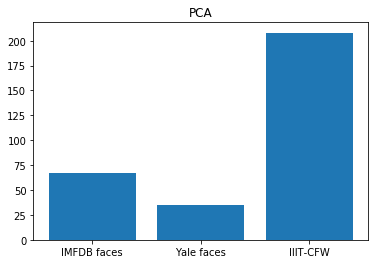

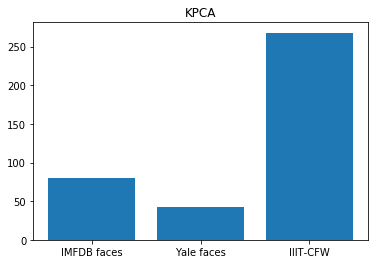

In [742]:
# code goes here
#for 90% threshold, to preserve 90% of the variance

#normal PCA
def pcastuff(X):
    N,H,W,C = X.shape
    X=X.reshape((N,H*W*C))
    pca = PCA()
    pca.fit(X)
    sv = np.sort(pca.explained_variance_ratio_)
    sv = sv[::-1]
    sum_sv = 0
    for ev in range(len(sv)):
        if sum_sv <= 0.9*np.sum(sv):
            sum_sv += sv[ev] 
        else:
            break
    return ev

imfdb_ev = pcastuff(X_orig)
yale_ev = pcastuff(X2_orig)
iiit_ev = pcastuff(X3_orig)

ev_list = [imfdb_ev,yale_ev,iiit_ev]
index = ['IMFDB faces','Yale faces','IIIT-CFW']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(index, ev_list)
plt.title("PCA")

#kernel PCA

def kpcastuff(X):
    N,H,W,C = X.shape
    X=X.reshape((N,H*W*C))
    _,kpca = get_kernel_pca(X,k=None)
    sv = np.sort(kpca.lambdas_)
    sv = sv[::-1]
    sum_sv = 0
    for ev in range(len(sv)):
        if sum_sv <= 0.9*np.sum(sv):
            sum_sv += sv[ev] 
        else:
            break
    return ev

kimfdb_ev = kpcastuff(X_orig)
kyale_ev = kpcastuff(X2_orig)
kiiit_ev = kpcastuff(X3_orig)

ev_list = [kimfdb_ev,kyale_ev,kiiit_ev]
index = ['IMFDB faces','Yale faces','IIIT-CFW']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(index, ev_list)
plt.title("KPCA")


1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [743]:
# Display results 
for i in range(len(eiglist)):
    X_reconstructed = reconstruct_images(eiglist[i], pcalist[i], list(orglist[i].shape))
    # Show the reconstruction error
    if  i == 0: #IMFDB data
        totclasses = 8
        print ("For IMFDB data,")
    elif i == 1:
        print ("For yale face data,")
        totclasses = 15
    else: #IIIT cartoon data
        print ("For IIIT cartoon data,")
        totclasses = 8
    classes = [0 for _ in range(totclasses)]
    perclass = len(X_reconstructed)/totclasses
    for k in range(len(X_reconstructed)):
        temp = np.sqrt(np.mean((orglist[i][k] - X_reconstructed[k])**2))
        classes[ys[i][k]] += temp
        
    classes = [x/perclass for x in classes]
    i=1
    for c in classes:
        print (i,c)
        i+=1
    print ("Max reconstruction error at class = " + str(classes.index(max(classes))+1))
        

For IMFDB data,
1 3.9017302944376997e-16
2 3.517248177755153e-16
3 3.0904358780070025e-16
4 4.1396772498922235e-16
5 3.998935641362699e-16
6 5.174291735039187e-16
7 3.9359842496737465e-16
8 4.472544533133213e-16
Max reconstruction error at class = 6
For yale face data,
1 4.82112384626379e-16
2 4.0818605454297383e-16
3 5.036398425601486e-16
4 4.1635675005672636e-16
5 5.13526974782665e-16
6 4.4349911181894953e-16
7 5.297278436536643e-16
8 4.569890939253025e-16
9 4.542963786536979e-16
10 4.485720152911798e-16
11 6.496265759375182e-16
12 4.707175605702334e-16
13 5.081179482843633e-16
14 3.952765804256716e-16
15 5.351722523907647e-16
Max reconstruction error at class = 11
For IIIT cartoon data,
1 4.1050760592985734e-16
2 3.5753715059035245e-16
3 5.784635215394383e-16
4 8.028492211355163e-16
5 7.788222847961315e-16
6 7.808399247924502e-16
7 8.022839593780964e-16
8 7.85765559778356e-16
Max reconstruction error at class = 4


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [744]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree

class Classifier():
    def __init__(self):
#         super.__init__()
        self.MLP_clf = MLPClassifier(solver='lbfgs',activation='relu',hidden_layer_sizes=(256, 128))
        self.LR_clf = LogisticRegression(solver='lbfgs',random_state=13, multi_class='multinomial')
        self.SVM_clf = SVC(gamma='auto') 
        self.Tree_clf = tree.DecisionTreeClassifier()
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X,cl_type):
        """
            Given an input X classify it into appropriate class. 
        """
        if cl_type == "MLP":
            prediction = self.MLP_clf.predict(X)
        elif cl_type == "LR":
            prediction = self.LR_clf.predict(X)
        elif cl_type == "SVM":
            prediction = self.SVM_clf.predict(X)
        elif cl_type == "Dtree":
            prediction = self.Tree_clf.predict(X)
        else:
            print ("Wrong classifier type given.")
            return -1
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cmat = confusion_matrix(y,pred)
        return cmat
        
    def train(self,X_train,y_train, cl_type):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        if cl_type == 'MLP' : 
            self.MLP_clf.fit(X_train,y_train)
        elif cl_type == 'LR' :
            self.LR_clf.fit(X_train, y_train)
        elif cl_type == 'SVM' :
            self.SVM_clf.fit(X_train, y_train)
        elif cl_type == 'Dtree' :
            self.Tree_clf.fit(X_train, y_train)
        else : 
            print("Wrong type given.")
        
    def validate(self,X_validate,y_validate,cl_type):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        prediction = self.classify(X_validate,cl_type)         

        # Create a confusion matrix
        conf_mat = self.confusion_matrix(prediction,y_validate)
#         print (conf_mat)
        
        # Calculate Validation accuracy 
        if cl_type == 'MLP' : 
            accuracy = self.MLP_clf.score(X_validate,y_validate)
        elif cl_type == 'SVM' :
            accuracy = self.SVM_clf.score(X_validate, y_validate)
        elif cl_type == 'LR' :
            accuracy = self.LR_clf.score(X_validate, y_validate)
        elif cl_type == 'Dtree' :
            accuracy = self.Tree_clf.score(X_validate, y_validate)        
        else : 
            print("Wrong type given.")
            return -1   
#         print(accuracy)
        
        # Calculate precision and recall         
        recall = recall_score(y_validate, prediction, average='macro')  
#         print("Recall :",recall)

        precision = precision_score(y_validate, prediction, average='macro') 
#         print("Precision :",precision)
        
        # Calculate F1-score        
        try:
            f1 = 2 * (precision * recall) / (precision + recall)
        except:
            f1 = f1_score(y_validate, prediction,average='micro')
#         print("F1 score :", f1)
        
        return accuracy,f1, conf_mat,recall,precision 

cl = Classifier()

In [745]:
# Loading the dataset
# eg.
dirpath1 = './dataset/IMFDB/'
X_orig,y1 = load_data(dirpath1)
X1 = X_orig
N,H,W = X1.shape[0:3]
C = 1 if opt['is_grayscale'] else X1.shape[3]

# Flatten to apply PCA/LDA
X1 = X1.reshape((N,H*W*C))

dirpath2 = './dataset/Yale_face_database/'
X2_orig,y2 = load_data(dirpath2)
X2 = X2_orig
N,H,W = X2.shape[0:3]
C = 1 if opt['is_grayscale'] else X2.shape[3]

# Flatten to apply PCA/LDA
X2 = X2.reshape((N,H*W*C))

dirpath3 = './dataset/IIIT-CFW/'
X3_orig,y3 = load_data(dirpath3)
X3 = X3_orig
N,H,W = X3.shape[0:3]
C = 1 if opt['is_grayscale'] else X3.shape[3]

# Flatten to apply PCA/LDA
X3 = X3.reshape((N,H*W*C))

Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)


In [746]:
# Create a train and validation split to train your classifier 
from sklearn.model_selection import train_test_split

classifiers = ["LR","SVM","MLP","Dtree"]

#IMFDB
print ("Classifying on IMFDB data:")
imf_acc, imf_f1 = [],[]
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2)
for clf in classifiers:
    print (clf)
    cl.train(X_train,y_train,clf)
    acc,f1,conf_mat,rec,prec = cl.validate(X_test,y_test,clf)
    imf_acc.append(acc)
    imf_f1.append(f1)
    print ("Confusion matrix: ",conf_mat)
    print("Accuracy :",acc)
    print("Recall :",rec)
    print ("Precision:", prec)
        
#YALE
print ("Classifying on Yale data:")
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2)
yale_acc, yale_f1 = [],[]
for clf in classifiers:
    print (clf)
    cl.train(X_train,y_train,clf)
    acc,f1,conf_mat,rec,prec = cl.validate(X_test,y_test,clf)
    yale_acc.append(acc)
    yale_f1.append(f1)
    print ("Confusion matrix: ",conf_mat)
    print("Accuracy :",acc)
    print("Recall :",rec)
    print ("Precision:", prec)

#IIITH-CFW
print ("Classifying on IIITH-CFW data:")
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2)
iiit_acc, iiit_f1 = [],[]
for clf in classifiers:
    print (clf)
    cl.train(X_train,y_train,clf)
    acc,f1,conf_mat,rec,prec = cl.validate(X_test,y_test,clf)
    iiit_acc.append(acc)
    iiit_f1.append(f1)
    print ("Confusion matrix: ",conf_mat)
    print("Accuracy :",acc)
    print("Recall :",rec)
    print ("Precision:", prec)

Classifying on IMFDB data:
LR


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Confusion matrix:  [[13  0  0  0  0  0  0  0]
 [ 1  4  1  1  0  0  0  0]
 [ 0  0  9  0  0  0  0  1]
 [ 0  1  0  4  0  0  1  0]
 [ 0  2  0  0 10  1  0  0]
 [ 0  0  0  0  0  7  1  0]
 [ 0  0  0  2  0  0 10  0]
 [ 0  0  1  0  0  1  1  8]]
Accuracy : 0.8125
Recall : 0.7928665084915085
Precision: 0.7906884781884782
SVM


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:  [[13  0  0  0  0  0  0  0]
 [ 1  1  0  5  0  0  0  0]
 [ 2  2  0  6  0  0  0  0]
 [ 0  0  0  4  0  1  1  0]
 [ 0  2  0 11  0  0  0  0]
 [ 0  0  0  1  0  6  1  0]
 [ 3  1  0  4  0  0  4  0]
 [ 1  0  0  7  0  0  3  0]]
Accuracy : 0.35
Recall : 0.3616071428571428
Precision: 0.2779396407685881
MLP
Confusion matrix:  [[12  0  0  0  0  0  1  0]
 [ 0  5  1  0  0  1  0  0]
 [ 0  0  9  1  0  0  0  0]
 [ 0  0  0  6  0  0  0  0]
 [ 0  1  1  0 11  0  0  0]
 [ 0  0  0  0  0  7  1  0]
 [ 0  0  0  2  0  0  9  1]
 [ 0  0  1  1  0  1  0  8]]
Accuracy : 0.8375
Recall : 0.8419736513486513
Precision: 0.8335227272727272
Dtree
Confusion matrix:  [[6 2 0 2 0 0 2 1]
 [1 3 2 0 1 0 0 0]
 [1 1 5 0 1 0 1 1]
 [0 1 0 2 0 1 1 1]
 [0 0 1 1 7 0 1 3]
 [0 0 0 0 0 7 0 1]
 [0 2 1 2 0 0 7 0]
 [0 2 5 0 0 0 2 2]]
Accuracy : 0.4875
Recall : 0.48775703463203457
Precision: 0.505073051948052
Classifying on Yale data:
LR


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:  [[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
Accuracy : 0.9696969696969697
Recall : 0.9777777777777777
Precision: 0.9777777777777777
SVM
Confusion matrix:  [[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 3]
 [0 0 0 0 0 1 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1

/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:  [[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
Accuracy : 0.8484848484848485
Recall : 0.8722222222222221
Precision: 0.8333333333333333
Dtree
Confusion matrix:  [[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 2 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0

/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Confusion matrix:  [[ 3  0  1  2  1  0  0  0]
 [ 0  2  0  2  0  1  0  0]
 [ 0  1  9  0  3  1  1  1]
 [ 5  1  3 12  0  0  1  1]
 [ 2  0  2  0 13  1  1  1]
 [ 0  0  3  2  2  8  0  7]
 [ 0  0  1  0  0  1 19  0]
 [ 0  0  7  1  2  2  1  8]]
Accuracy : 0.5481481481481482
Recall : 0.5265201510446076
Precision: 0.5298425481205802
SVM


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix:  [[ 0  0  4  2  0  0  0  1]
 [ 0  0  0  3  2  0  0  0]
 [ 0  0  6  0  2  0  0  8]
 [ 0  0  3 17  1  0  1  1]
 [ 0  0  1  0 13  0  3  3]
 [ 0  0  3  3  1  2  0 13]
 [ 0  0  1  1  0  1 15  3]
 [ 0  0  1  2  1  0  1 16]]
Accuracy : 0.5111111111111111
Recall : 0.416403750235272
Precision: 0.41814431913116124
MLP
Confusion matrix:  [[ 3  1  1  1  1  0  0  0]
 [ 0  1  0  2  1  1  0  0]
 [ 1  0  8  0  4  1  0  2]
 [ 4  1  4 12  0  0  0  2]
 [ 2  1  2  1 11  0  0  3]
 [ 3  0  1  3  1  7  0  7]
 [ 1  0  1  0  1  2 16  0]
 [ 0  0  6  3  3  3  0  6]]
Accuracy : 0.4740740740740741
Recall : 0.4457639281008846
Precision: 0.45719579333709764
Dtree
Confusion matrix:  [[ 1  0  2  2  0  2  0  0]
 [ 2  1  0  0  1  0  0  1]
 [ 0  5  3  0  2  3  1  2]
 [ 5  0  6  1  0  7  1  3]
 [ 1  2  2  2  6  4  0  3]
 [ 0  1  3  3  1  7  1  6]
 [ 0  0  3  2  3  0 12  1]
 [ 2  1  1  2  4  3  2  6]]
Accuracy : 0.2740740740740741
Recall : 0.2561450098814229
Precision: 0.25312799945152886


In [747]:
# Create 3 tables similar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
imf_df = []
yale_df = []
iiit_df = []

feats = ['pca','kpca','lda','klda','vgg','resnet','pca+kpca','lda+klda']
classifiers = ["LR","SVM","MLP","Dtree"]

cl = Classifier()

#IMFDB dataset
X,y=X1,y1
c1 = []
feature_list, dimension_list,classification_error_list,accuracy_list,f1score_list = [],[],[],[],[]
for f in feats:
    for clf in classifiers:
        if f == 'pca':
            dims = imfdb_ev
            X_k, _ = get_pca(X,dims)
        elif f == "kpca":
            dims = kimfdb_ev
            X_k, _ = get_kernel_pca(X,dims)
        elif f == "lda":
            dims = imfdb_lda_ev 
            X_k, _ = get_lda(X,y,dims)
        elif f == "klda":
            dims = imfdb_klda_ev 
            X_k, _ = get_kernel_lda(X,y,dims)
        elif f == 'vgg':
            X_k = get_vgg_features(dirpath1)
            dims = X_k.shape[1] 
        elif f == "resnet":
            X_k = get_resnet_features(dirpath1)
            dims = X_k.shape[1]
        elif f == "pca+kpca":
            dims = imfdb_ev + kimfdb_ev
            X_k1, _ = get_pca(X,imfdb_ev)
            X_k2, _ = get_kernel_pca(X,kimfdb_ev)
            X_k = np.hstack([X_k1,X_k2])
        elif f == "lda+klda":
            dims = imfdb_lda_ev + imfdb_klda_ev
            X_k1, _ = get_lda(X,y,imfdb_lda_ev)
            X_k2, _ = get_kernel_lda(X,y,imfdb_klda_ev)
            X_k = np.hstack([X_k1,X_k2])
            
        X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2)
        cl.train(X_train,y_train,clf)
        acc,f1,cmat,_,_ = cl.validate(X_test,y_test,clf)
        
        feature_list.append(str(f) + " with " + str(clf))
        dimension_list.append(dims)
        classification_error_list.append(1-acc)
        accuracy_list.append(acc)
        f1score_list.append(f1)

        if f1 == max(f1score_list):
            c1 = cmat
            
data = {'Method': feature_list,'Dimensions': dimension_list,
        'Classification Error': classification_error_list,
        'Accuracy': accuracy_list,'f1-score':f1score_list}
imf_df = pd.DataFrame(data)

# Print the table. (You can use Pandas)
print (max(f1score_list))
imf_df


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/s

0.9899838122217726


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


,Method,Dimensions,Classification Error,Accuracy,f1-score
0,pca with LR,67,0.2375,0.7625,0.782478
1,pca with SVM,67,0.2000,0.8000,0.814215
2,pca with MLP,67,0.2500,0.7500,0.754898
3,pca with Dtree,67,0.4375,0.5625,0.573515
4,kpca with LR,80,0.4250,0.5750,0.640795
5,kpca with SVM,80,0.9125,0.0875,0.020115
6,kpca with MLP,80,0.3250,0.6750,0.669506
7,kpca with Dtree,80,0.5625,0.4375,0.461683
8,lda with LR,6,0.0750,0.9250,0.924090
9,lda with SVM,6,0.0375,0.9625,0.967803


In [748]:
#Yale face dataset
feature_list, dimension_list,classification_error_list,accuracy_list,f1score_list = [],[],[],[],[]
X,y=X2,y2
c2 = []

for f in feats:
    for clf in classifiers:
        if f == 'pca':
            dims = yale_ev
            X_k, _ = get_pca(X,dims)
        elif f == "kpca":
            dims = kyale_ev
            X_k, _ = get_kernel_pca(X,dims)
        elif f == "lda":
            dims = yale_lda_ev 
            X_k, _ = get_lda(X,y,dims)
        elif f == "klda":
            dims = yale_klda_ev 
            X_k, _ = get_kernel_lda(X,y,dims)
        elif f == 'vgg':
            X_k = get_vgg_features(dirpath2)
            dims = X_k.shape[1] 
        elif f == "resnet":
            X_k = get_resnet_features(dirpath2)
            dims = X_k.shape[1]
        elif f == "pca+kpca":
            dims = yale_ev + kyale_ev
            X_k1, _ = get_pca(X,yale_ev)
            X_k2, _ = get_kernel_pca(X,kyale_ev)
            X_k = np.hstack([X_k1,X_k2])
        elif f == "lda+klda":
            dims = yale_lda_ev + yale_klda_ev
            X_k1, _ = get_lda(X,y,yale_lda_ev)
            X_k2, _ = get_kernel_lda(X,y,yale_klda_ev)
            X_k = np.hstack([X_k1,X_k2])
            
        X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2)
        cl.train(X_train,y_train,clf)
        acc,f1,cmat,_,_= cl.validate(X_test,y_test,clf)
        
        feature_list.append(str(f) + " with " + str(clf))
        dimension_list.append(dims)
        classification_error_list.append(1-acc)
        accuracy_list.append(acc)
        f1score_list.append(f1)
                
        if f1 == max(f1score_list):
            c2 = cmat  
            
data = {'Method': feature_list,'Dimensions': dimension_list,
        'Classification Error': classification_error_list,
        'Accuracy': accuracy_list,'f1-score':f1score_list}
yale_df = pd.DataFrame(data)

# Print the table. (You can use Pandas)
print (max(f1score_list))
yale_df


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classific

1.0


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


,Method,Dimensions,Classification Error,Accuracy,f1-score
0,pca with LR,35,0.090909,0.909091,0.865816
1,pca with SVM,35,0.151515,0.848485,0.901540
2,pca with MLP,35,0.121212,0.878788,0.924925
3,pca with Dtree,35,0.333333,0.666667,0.579291
4,kpca with LR,42,0.454545,0.545455,0.634464
5,kpca with SVM,42,1.000000,0.000000,NaN
6,kpca with MLP,42,0.060606,0.939394,0.897310
7,kpca with Dtree,42,0.393939,0.606061,0.567699
8,lda with LR,10,0.000000,1.000000,1.000000
9,lda with SVM,10,0.060606,0.939394,0.961538


In [749]:
#IIIT-CFW dataset
feature_list, dimension_list,classification_error_list,accuracy_list,f1score_list = [],[],[],[],[]
X,y=X3,y3
c3 = []
for f in feats:
    for clf in classifiers:
        if f == 'pca':
            dims = iiit_ev
            X_k, _ = get_pca(X,dims)
        elif f == "kpca":
            dims = kiiit_ev
            X_k, _ = get_kernel_pca(X,dims)
        elif f == "lda":
            dims = iiit_lda_ev 
            X_k, _ = get_lda(X,y,dims)
        elif f == "klda":
            dims = iiit_klda_ev 
            X_k, _ = get_kernel_lda(X,y,dims)
        elif f == 'vgg':
            X_k = get_vgg_features(dirpath3)
            dims = X_k.shape[1] 
        elif f == "resnet":
            X_k = get_resnet_features(dirpath3)
            dims = X_k.shape[1]
        elif f == "pca+kpca":
            dims = iiit_ev + kiiit_ev
            X_k1, _ = get_pca(X,iiit_ev)
            X_k2, _ = get_kernel_pca(X,kiiit_ev)
            X_k = np.hstack([X_k1,X_k2])
        elif f == "lda+klda":
            dims = iiit_lda_ev + iiit_klda_ev
            X_k1, _ = get_lda(X,y,iiit_lda_ev)
            X_k2, _ = get_kernel_lda(X,y,iiit_klda_ev)
            X_k = np.hstack([X_k1,X_k2])
            
        X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2)
        cl.train(X_train,y_train,clf)
        acc,f1,cmat,_,_ = cl.validate(X_test,y_test,clf)
        
        feature_list.append(str(f) + " with " + str(clf))
        dimension_list.append(dims)
        classification_error_list.append(1-acc)
        accuracy_list.append(acc)
        f1score_list.append(f1)
            
        if f1 == max(f1score_list):
            c3 = cmat
            
data = {'Method': feature_list,'Dimensions': dimension_list,
        'Classification Error': classification_error_list,
        'Accuracy': accuracy_list,'f1-score':f1score_list}
iiit_df = pd.DataFrame(data)

# Print the table. (You can use Pandas)
print (max(f1score_list))
iiit_df


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warni

1.0


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


,Method,Dimensions,Classification Error,Accuracy,f1-score
0,pca with LR,208,0.525926,0.474074,0.491910
1,pca with SVM,208,0.355556,0.644444,0.638395
2,pca with MLP,208,0.481481,0.518519,0.505088
3,pca with Dtree,208,0.740741,0.259259,0.267328
4,kpca with LR,268,0.437037,0.562963,0.533600
5,kpca with SVM,268,0.903704,0.096296,0.021959
6,kpca with MLP,268,0.437037,0.562963,0.562970
7,kpca with Dtree,268,0.740741,0.259259,0.225443
8,lda with LR,6,0.044444,0.955556,0.941661
9,lda with SVM,6,0.029630,0.970370,0.966968


In [750]:
# For each dataset print the confusion matrix for the best model 

#IMFDB dataset - best model gave accuracy of 1
#LDA with LR
print ("For IMFDB, LDA with LR:")
print (c1)
print ('\n')
#Yale dataset - best models gave accuracy of 1
#LDA with SVM, KLDA with LR, KLDA with MLP, PCA+KPCA with LR, LDA+KLDA with LR, LDA+KLDA with MLP
print ("For Yale, LDA+KLDA with LR:")
print (c2)
print ('\n')

#IIIT dataset - best model gave accuracy of 0.98516
#resnet with LR
print ("For IIIT-CFW, resnet with LR:")
print (c3)

For IMFDB, LDA with LR:
[[11  0  0  0  0  0  0  0]
 [ 0 12  0  0  1  0  0  0]
 [ 0  0 12  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0]
 [ 0  0  0  0 11  0  0  0]
 [ 0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  8]]


For Yale, LDA+KLDA with LR:
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3]]


For IIIT-CFW, resnet with LR:
[[ 9  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0]
 [ 0  0 16  0  0  0  0  0]
 [ 0  0  0 27  0  0  0  0]
 [ 0  0  0  0 19  0  0  0]
 [ 0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0 17  0]
 [ 0  0  0  

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


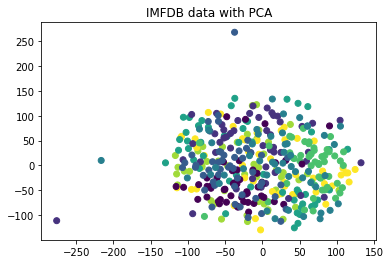

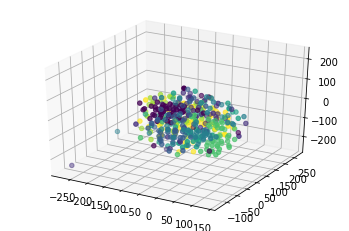

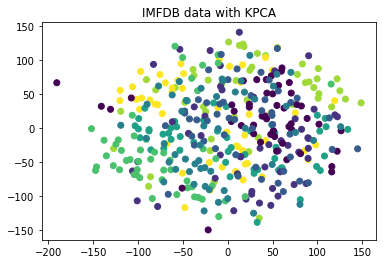

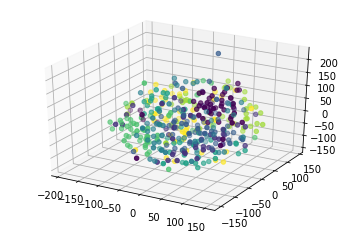

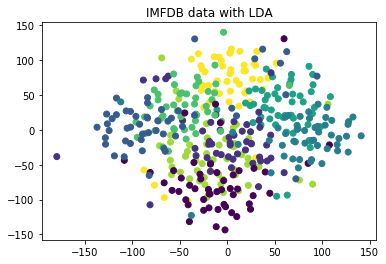

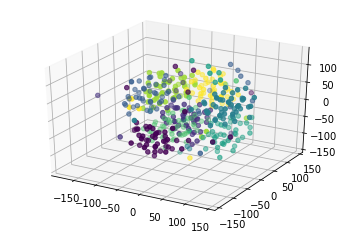

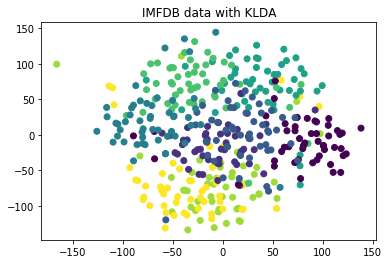

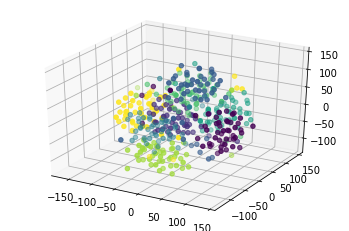

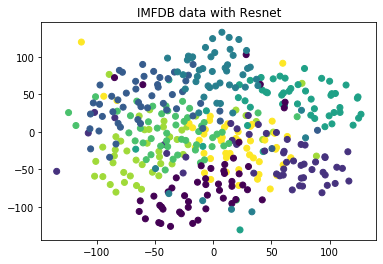

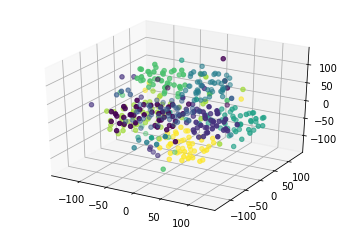

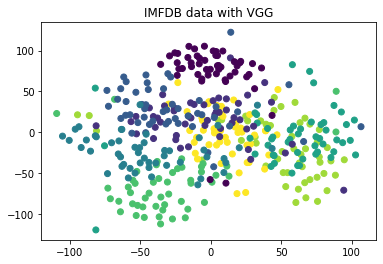

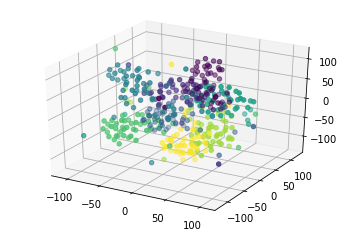

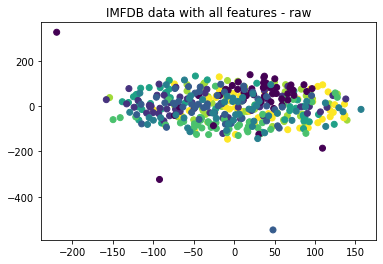

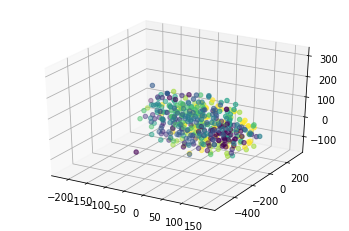

/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


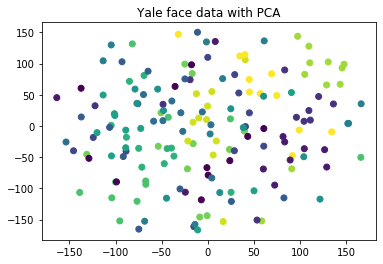

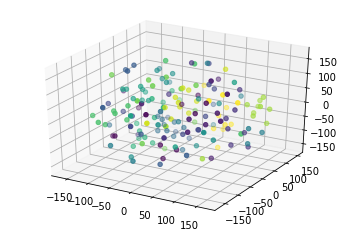

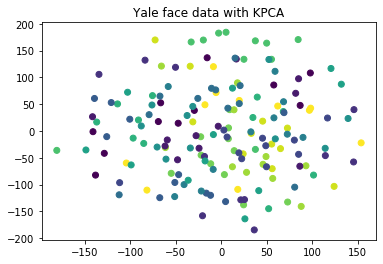

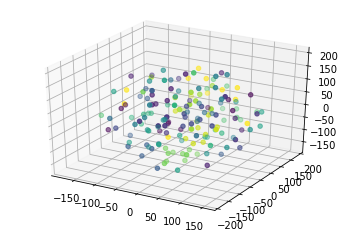

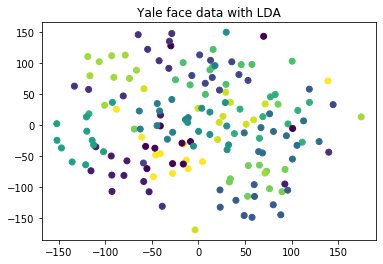

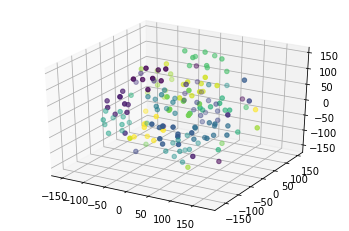

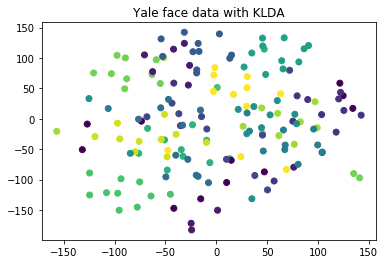

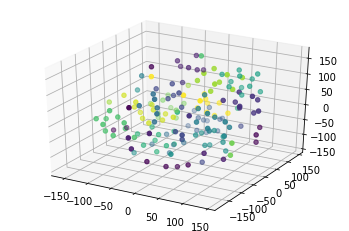

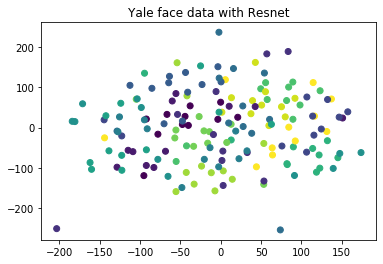

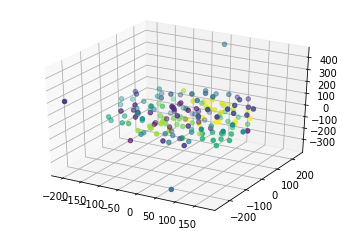

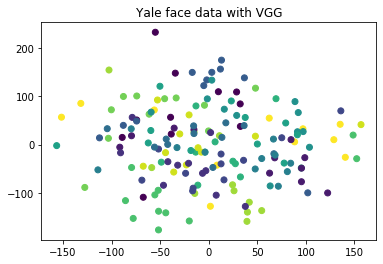

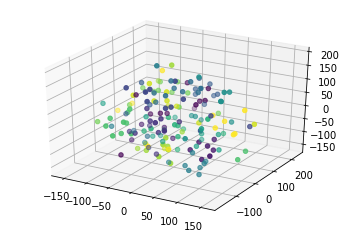

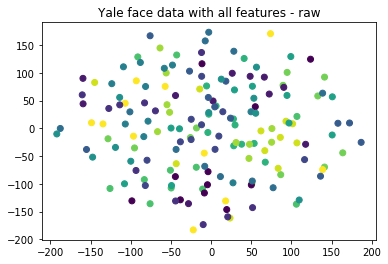

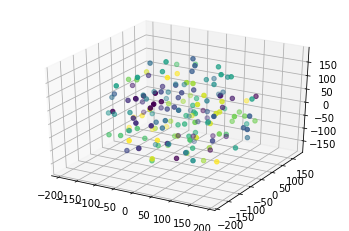

/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


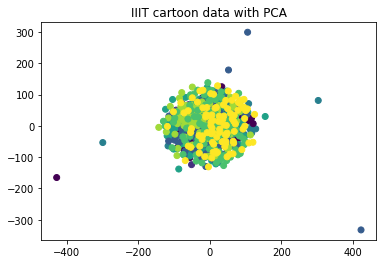

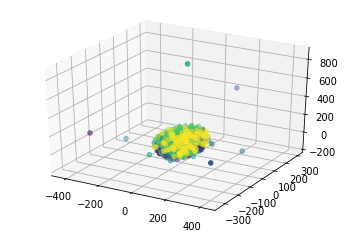

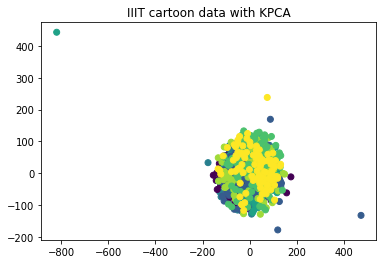

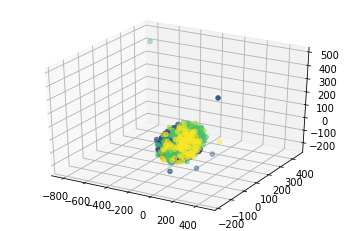

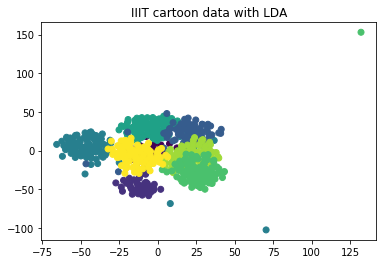

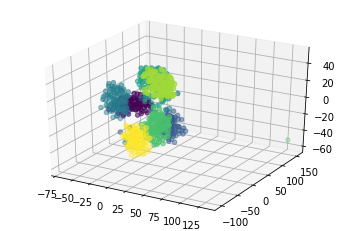

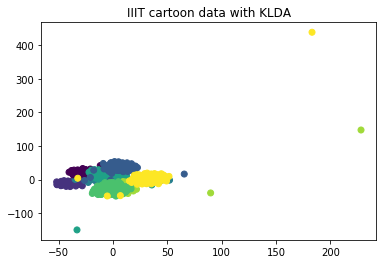

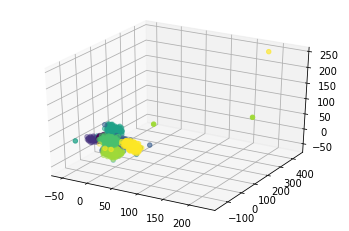

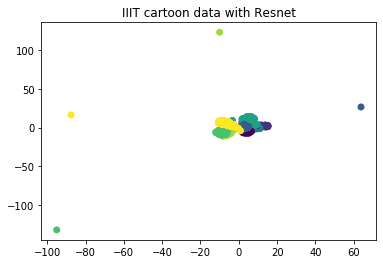

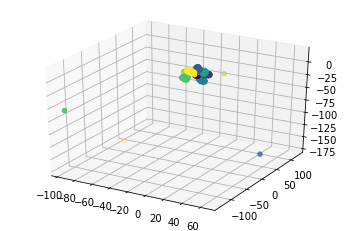

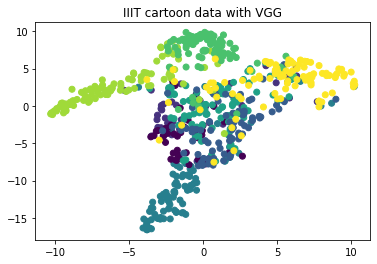

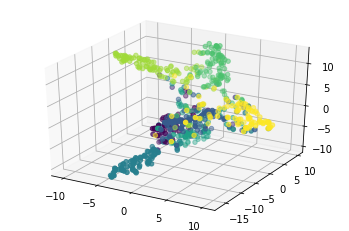

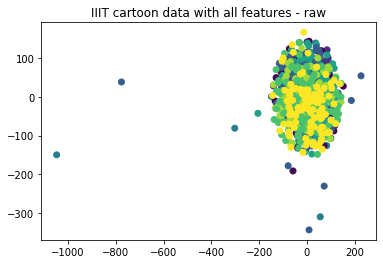

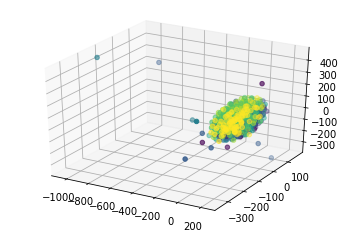

In [751]:
# Compute TSNE for different features and create a scatter plot

from mpl_toolkits.mplot3d import Axes3D

def showtsne(Xlist,data,y):
    k = 3 # Number of components in TSNE
    for i in range(len(Xlist)):
        # Compute
        tsne = TSNE(n_components=k).fit_transform(Xlist[i])

        # Plot the representation in 2d/3d
#         plt.scatter(*zip(*tsne[:,:2]), c=Xlist[i][:,2], cmap='RdBu')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(tsne[:,0],tsne[:,1],c=y)
        plt.title(data + " with " + str(legend[i]))
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
#         ax.scatter(*zip(*tsne), c=Xlist[i][:,2], cmap='RdBu')
        ax.scatter(tsne[:,0],tsne[:,1],tsne[:,2],c=y)
        
        plt.show()
        
        
        
titles = ["IMFDB data","Yale face data","IIIT cartoon data"]
legend = ["PCA", "KPCA","LDA","KLDA","Resnet","VGG","all features - raw"]

#imfdb
a,_ = get_pca(X1,imfdb_ev)
b,_ = get_kernel_pca(X1,kimfdb_ev)
c,_ = get_lda(X1,y1,imfdb_lda_ev)
d,_ = get_kernel_lda(X1,y1,imfdb_klda_ev)
e = get_resnet_features(dirpath1)
f = get_vgg_features(dirpath1)
g = X1

Xlist = [a,b,c,d,e,f,g] 
showtsne(Xlist,titles[0],y1)
    
#yale
a,_ = get_pca(X2,yale_ev)
b,_ = get_kernel_pca(X2,kyale_ev)
c,_ = get_lda(X2,y2,yale_lda_ev)
d,_ = get_kernel_lda(X2,y2,yale_klda_ev)
e = get_resnet_features(dirpath2)
f = get_vgg_features(dirpath2)
g = X2
Xlist = [a,b,c,d,e,f,g] 
showtsne(Xlist,titles[1],y2)

#iiit-cfw
a,_ = get_pca(X3,iiit_ev)
b,_ = get_kernel_pca(X3,kiiit_ev)
c,_ = get_lda(X3,y3,iiit_lda_ev)
d,_ = get_kernel_lda(X3,y3,iiit_klda_ev)
e = get_resnet_features(dirpath3)
f = get_vgg_features(dirpath3)
g = X3
Xlist = [a,b,c,d,e,f,g] 
showtsne(Xlist,titles[2],y3)


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [752]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score

class FaceVerification():
    def __init__(self,n):
        self.knn = KNeighborsClassifier(n_neighbors=n)
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        prediction = self.knn.predict(X)
        verfication_results = np.array([prediction[i] == class_id[i] for i in range(len(prediction))])    
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        try:
            self.knn.fit(X_train,y_train)
        except:
            print ("Error in training")
            return 0

        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        prediction = self.knn.predict(X_validate) 
        precision = precision_score(y_validate, prediction, average='micro')
#         print ("Precision: ", precision)
        accuracy = self.knn.score(X_validate, y_validate)
#         print ("Accuracy: ", accuracy)
        return accuracy, precision  
         

In [753]:
# Create a train and validation split and show your results 

xlist = [X1,X2,X3]
ylist = [y1,y2,y3]
nns = [3,5,17,25]
for i in range(len(xlist)):
    X=xlist[i]
    y=ylist[i]
    print ("\nFor dataset ",i+1)    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

    for n in nns: 
        fv = FaceVerification(n)
        fv.train(X_train,y_train)
        accuracy, prec = fv.validate(X_test,y_test)
        print("For N = ", n)
        print ("Accuracy: ",accuracy)
        print ("Precision: ",prec)
        
    


For dataset  1
For N =  3
Accuracy:  0.5875
Precision:  0.5875
For N =  5
Accuracy:  0.575
Precision:  0.575
For N =  17
Accuracy:  0.5875
Precision:  0.5875
For N =  25
Accuracy:  0.5
Precision:  0.5

For dataset  2
For N =  3
Accuracy:  0.7575757575757576
Precision:  0.7575757575757576
For N =  5
Accuracy:  0.7272727272727273
Precision:  0.7272727272727273
For N =  17
Accuracy:  0.45454545454545453
Precision:  0.45454545454545453
For N =  25
Accuracy:  0.42424242424242425
Precision:  0.42424242424242425

For dataset  3
For N =  3
Accuracy:  0.32592592592592595
Precision:  0.32592592592592595
For N =  5
Accuracy:  0.26666666666666666
Precision:  0.26666666666666666
For N =  17
Accuracy:  0.3037037037037037
Precision:  0.3037037037037037
For N =  25
Accuracy:  0.3111111111111111
Precision:  0.3111111111111111


In [754]:
# Create 3 tables similar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

imf_df = []
yale_df = []
iiit_df = []

feats = ['pca','kpca','lda','klda','vgg','resnet','pca+kpca','lda+klda']


#IMFDB dataset
X,y=X1,y1
c1 = []
feature_list, dimension_list,classification_error_list,accuracy_list, prec_list = [],[],[],[],[]
for f in feats:
    for n in nns:
        fv = FaceVerification(n)
        
        if f == 'pca':
            dims = imfdb_ev
            X_k, _ = get_pca(X,dims)
        elif f == "kpca":
            dims = kimfdb_ev
            X_k, _ = get_kernel_pca(X,dims)
        elif f == "lda":
            dims = imfdb_lda_ev 
            X_k, _ = get_lda(X,y,dims)
        elif f == "klda":
            dims = imfdb_klda_ev 
            X_k, _ = get_kernel_lda(X,y,dims)
        elif f == 'vgg':
            X_k = get_vgg_features(dirpath1)
            dims = X_k.shape[1] 
        elif f == "resnet":
            X_k = get_resnet_features(dirpath1)
            dims = X_k.shape[1]
        elif f == "pca+kpca":
            dims = imfdb_ev + kimfdb_ev
            X_k1, _ = get_pca(X,imfdb_ev)
            X_k2, _ = get_kernel_pca(X,kimfdb_ev)
            X_k = np.hstack([X_k1,X_k2])
        elif f == "lda+klda":
            dims = imfdb_lda_ev + imfdb_klda_ev
            X_k1, _ = get_lda(X,y,imfdb_lda_ev)
            X_k2, _ = get_kernel_lda(X,y,imfdb_klda_ev)
            X_k = np.hstack([X_k1,X_k2])
            
        X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2)
        fv.train(X_train,y_train)
        acc,prec = fv.validate(X_test,y_test)
        
        feature_list.append(str(f) + " with KNN at NN=" + str(n))
        dimension_list.append(dims)
        classification_error_list.append(1-acc)
        accuracy_list.append(acc)
        prec_list.append(prec)

            
data = {'Method': feature_list,'Dimensions': dimension_list,
        'Classification Error': classification_error_list,
        'Accuracy': accuracy_list,'Precision':prec_list}
imf_df = pd.DataFrame(data)

# Print the table. (You can use Pandas)
imf_df


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

,Method,Dimensions,Classification Error,Accuracy,Precision
0,pca with KNN at NN=3,67,0.4250,0.5750,0.5750
1,pca with KNN at NN=5,67,0.3625,0.6375,0.6375
2,pca with KNN at NN=17,67,0.4500,0.5500,0.5500
3,pca with KNN at NN=25,67,0.5625,0.4375,0.4375
4,kpca with KNN at NN=3,80,0.2875,0.7125,0.7125
5,kpca with KNN at NN=5,80,0.4000,0.6000,0.6000
6,kpca with KNN at NN=17,80,0.4500,0.5500,0.5500
7,kpca with KNN at NN=25,80,0.5250,0.4750,0.4750
8,lda with KNN at NN=3,6,0.0125,0.9875,0.9875
9,lda with KNN at NN=5,6,0.0250,0.9750,0.9750


In [755]:
# Create 3 tables similar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

yale_df = []

#yale dataset
X,y=X2,y2

feature_list, dimension_list,classification_error_list,accuracy_list, prec_list = [],[],[],[],[]
for f in feats:
    for n in nns:
        fv = FaceVerification(n)
        
        if f == 'pca':
            dims = yale_ev
            X_k, _ = get_pca(X,dims)
        elif f == "kpca":
            dims = kyale_ev
            X_k, _ = get_kernel_pca(X,dims)
        elif f == "lda":
            dims = yale_lda_ev 
            X_k, _ = get_lda(X,y,dims)
        elif f == "klda":
            dims = yale_klda_ev 
            X_k, _ = get_kernel_lda(X,y,dims)
        elif f == 'vgg':
            X_k = get_vgg_features(dirpath2)
            dims = X_k.shape[1] 
        elif f == "resnet":
            X_k = get_resnet_features(dirpath2)
            dims = X_k.shape[1]
        elif f == "pca+kpca":
            dims = yale_ev + kyale_ev
            X_k1, _ = get_pca(X,yale_ev)
            X_k2, _ = get_kernel_pca(X,kyale_ev)
            X_k = np.hstack([X_k1,X_k2])
        elif f == "lda+klda":
            dims = yale_lda_ev + yale_klda_ev
            X_k1, _ = get_lda(X,y,yale_lda_ev)
            X_k2, _ = get_kernel_lda(X,y,yale_klda_ev)
            X_k = np.hstack([X_k1,X_k2])
            
        X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2)
        fv.train(X_train,y_train)
        acc,prec = fv.validate(X_test,y_test)
        
        feature_list.append(str(f) + " with KNN at NN=" + str(n))
        dimension_list.append(dims)
        classification_error_list.append(1-acc)
        accuracy_list.append(acc)
        prec_list.append(prec)

            
data = {'Method': feature_list,'Dimensions': dimension_list,
        'Classification Error': classification_error_list,
        'Accuracy': accuracy_list,'Precision':prec_list}
yale_df = pd.DataFrame(data)

# Print the table. (You can use Pandas)
yale_df


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

,Method,Dimensions,Classification Error,Accuracy,Precision
0,pca with KNN at NN=3,35,0.151515,0.848485,0.848485
1,pca with KNN at NN=5,35,0.242424,0.757576,0.757576
2,pca with KNN at NN=17,35,0.484848,0.515152,0.515152
3,pca with KNN at NN=25,35,0.515152,0.484848,0.484848
4,kpca with KNN at NN=3,42,0.242424,0.757576,0.757576
5,kpca with KNN at NN=5,42,0.121212,0.878788,0.878788
6,kpca with KNN at NN=17,42,0.212121,0.787879,0.787879
7,kpca with KNN at NN=25,42,0.545455,0.454545,0.454545
8,lda with KNN at NN=3,10,0.000000,1.000000,1.000000
9,lda with KNN at NN=5,10,0.030303,0.969697,0.969697


In [756]:
# Create 3 tables similar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

iiit_df = []

#iiit dataset
X,y=X3,y3

feature_list, dimension_list,classification_error_list,accuracy_list, prec_list = [],[],[],[],[]
for f in feats:
    for n in nns:
        fv = FaceVerification(n)
        
        if f == 'pca':
            dims = iiit_ev
            X_k, _ = get_pca(X,dims)
        elif f == "kpca":
            dims = kiiit_ev
            X_k, _ = get_kernel_pca(X,dims)
        elif f == "lda":
            dims = iiit_lda_ev 
            X_k, _ = get_lda(X,y,dims)
        elif f == "klda":
            dims = iiit_klda_ev 
            X_k, _ = get_kernel_lda(X,y,dims)
        elif f == 'vgg':
            X_k = get_vgg_features(dirpath3)
            dims = X_k.shape[1] 
        elif f == "resnet":
            X_k = get_resnet_features(dirpath3)
            dims = X_k.shape[1]
        elif f == "pca+kpca":
            dims = iiit_ev + kiiit_ev
            X_k1, _ = get_pca(X,iiit_ev)
            X_k2, _ = get_kernel_pca(X,kiiit_ev)
            X_k = np.hstack([X_k1,X_k2])
        elif f == "lda+klda":
            dims = iiit_lda_ev + iiit_klda_ev
            X_k1, _ = get_lda(X,y,iiit_lda_ev)
            X_k2, _ = get_kernel_lda(X,y,iiit_klda_ev)
            X_k = np.hstack([X_k1,X_k2])
            
        X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2)
        fv.train(X_train,y_train)
        acc,prec = fv.validate(X_test,y_test)
        
        feature_list.append(str(f) + " with KNN at NN=" + str(n))
        dimension_list.append(dims)
        classification_error_list.append(1-acc)
        accuracy_list.append(acc)
        prec_list.append(prec)

            
data = {'Method': feature_list,'Dimensions': dimension_list,
        'Classification Error': classification_error_list,
        'Accuracy': accuracy_list,'Precision':prec_list}
iiit_df = pd.DataFrame(data)

# Print the table. (You can use Pandas)
iiit_df


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variabl

,Method,Dimensions,Classification Error,Accuracy,Precision
0,pca with KNN at NN=3,208,0.718519,0.281481,0.281481
1,pca with KNN at NN=5,208,0.703704,0.296296,0.296296
2,pca with KNN at NN=17,208,0.666667,0.333333,0.333333
3,pca with KNN at NN=25,208,0.666667,0.333333,0.333333
4,kpca with KNN at NN=3,268,0.696296,0.303704,0.303704
5,kpca with KNN at NN=5,268,0.696296,0.303704,0.303704
6,kpca with KNN at NN=17,268,0.688889,0.311111,0.311111
7,kpca with KNN at NN=25,268,0.674074,0.325926,0.325926
8,lda with KNN at NN=3,6,0.044444,0.955556,0.955556
9,lda with KNN at NN=5,6,0.029630,0.970370,0.970370


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [757]:
# Load data

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

dirpath = './dataset/IMFDB/'
X1,y1 = load_data(dirpath)
N1,H,W = X1.shape[0:3]
C = 1 if opt['is_grayscale'] else X1.shape[3]

cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

dirpath = './dataset/IIIT-CFW/'
X2,y2 = load_data(dirpath)
N2,H,W = X2.shape[0:3]
C = 1 if opt['is_grayscale'] else X2.shape[3]

X = np.vstack([X1,X2])
# Flatten to apply PCA/LDA
X = X.reshape((N1+N2,H*W*C))
# X.shape

#y=1 for male and 2 for female
y = [0 for _ in range(X.shape[0])]
for i in range(X.shape[0]):
    if i < N1:
        if y1[i] in [0,1,3,5]:
            y[i] = 2
        else:
            y[i] = 1
    else:
        if y2[i-N1] in [3]:
            y[i] = 2
        else:
            y[i] = 1
    

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)


In [758]:
# Define your features
def pcastuff(X):
    pca = PCA()
    pca.fit(X)
    sv = np.sort(pca.explained_variance_ratio_)
    sv = sv[::-1]
    sum_sv = 0
    for ev in range(len(sv)):
        if sum_sv <= 0.9*np.sum(sv):
            sum_sv += sv[ev] 
        else:
            break
    return ev

#kernel PCA
def kpcastuff(X):
    _,kpca = get_kernel_pca(X,k=None)
    sv = np.sort(kpca.lambdas_)
    sv = sv[::-1]
    sum_sv = 0
    for ev in range(len(sv)):
        if sum_sv <= 0.9*np.sum(sv):
            sum_sv += sv[ev] 
        else:
            break
    return ev
#normal LDA
def ldastuff(X,y):  
    _,lda = get_lda(X,y,k=None) 
    sv = np.sort(lda.explained_variance_ratio_)
    sv = sv[::-1]
    sum_sv = 0
    for ev in range(len(sv)):
        if sum_sv <= 0.9*np.sum(sv):
            sum_sv += sv[ev] 
        else:
            break
    return ev

#kernel LDA
def kldastuff(X,y): 
    _,klda = get_kernel_lda(X,y,k=None) 
    sv = np.sort(klda.explained_variance_ratio_)
    sv = sv[::-1]
    sum_sv = 0
    for ev in range(len(sv)):
        if sum_sv <= 0.9*np.sum(sv):
            sum_sv += sv[ev] 
        else:
            break
    return ev

pca_ev = pcastuff(X)
kpca_ev = kpcastuff(X)
lda_ev = ldastuff(X,y)
klda_ev = kldastuff(X,y)

/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [759]:
lda_ev = 1
klda_ev = 1

In [760]:
# Create your classifier
cl = Classifier()

# Validate your classifier

feats = ['pca','kpca','lda','klda','pca+kpca','lda+klda']
classifiers = ["LR","SVM","MLP","Dtree"]

feature_list, dimension_list,classification_error_list,accuracy_list,f1score_list = [],[],[],[],[]

c = []
for f in feats:
    for clf in classifiers:
        meth = str(f) + " with " + str(clf)
        print (meth)
        if f == 'pca':
            dims = pca_ev
            X_k, _ = get_pca(X,dims)
        elif f == "kpca":
            dims = kpca_ev
            X_k, _ = get_kernel_pca(X,dims)
        elif f == "lda":
            dims = lda_ev 
            X_k, _ = get_lda(X,y,dims)
        elif f == "klda":
            dims = klda_ev 
            X_k, _ = get_kernel_lda(X,y,dims)
        elif f == "pca+kpca":
            dims = pca_ev + kpca_ev
            X_k1, _ = get_pca(X,pca_ev)
            X_k2, _ = get_kernel_pca(X,kpca_ev)
            X_k = np.hstack([X_k1,X_k2])
        elif f == "lda+klda":
            dims = lda_ev + klda_ev
            X_k1, _ = get_lda(X,y,lda_ev)
            X_k2, _ = get_kernel_lda(X,y,klda_ev)
            X_k = np.hstack([X_k1,X_k2])
            
        X_train, X_test, y_train, y_test = train_test_split(X_k, y, test_size=0.2)
        cl.train(X_train,y_train,clf)
        acc,f1,cmat,_,_ = cl.validate(X_test,y_test,clf)
        
        feature_list.append(meth)
        dimension_list.append(dims)
        classification_error_list.append(1-acc)
        accuracy_list.append(acc)
        f1score_list.append(f1)
            
        if f1 == max(f1score_list):
            c3 = cmat
            
data = {'Method': feature_list,'Dimensions': dimension_list,
        'Classification Error': classification_error_list,
        'Accuracy': accuracy_list,'f1-score':f1score_list}
df = pd.DataFrame(data)

# Print the table. (You can use Pandas)
print (max(f1score_list))
df


pca with LR


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


pca with SVM
pca with MLP
pca with Dtree
kpca with LR
kpca with SVM


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


kpca with MLP
kpca with Dtree
lda with LR


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


lda with SVM


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


lda with MLP


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


lda with Dtree


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


klda with LR


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


klda with SVM


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


klda with MLP


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


klda with Dtree


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


pca+kpca with LR


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


pca+kpca with SVM
pca+kpca with MLP
pca+kpca with Dtree
lda+klda with LR


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


lda+klda with SVM


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


lda+klda with MLP


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


lda+klda with Dtree


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


1.0


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


,Method,Dimensions,Classification Error,Accuracy,f1-score
0,pca with LR,175,0.218605,0.781395,0.725237
1,pca with SVM,175,0.162791,0.837209,0.791381
2,pca with MLP,175,0.172093,0.827907,0.799763
3,pca with Dtree,175,0.283721,0.716279,0.666656
4,kpca with LR,243,0.204651,0.795349,0.703994
5,kpca with SVM,243,0.306977,0.693023,0.409341
6,kpca with MLP,243,0.181395,0.818605,0.778567
7,kpca with Dtree,243,0.237209,0.762791,0.714688
8,lda with LR,1,0.009302,0.990698,0.988064
9,lda with SVM,1,0.009302,0.990698,0.988557


In [761]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc. 

#best performing models: klda with LR, klda with SVM,lda+klda with LR, lda+klda with MLP
#pick any 2: klda with LR, klda with SVM

X_klda,_ = get_kernel_lda(X,y,k=None) 

#accuracy
X_train, X_test, y_train, y_test = train_test_split(X_klda, y, test_size=0.2)

SVM_clf = SVC(gamma='auto') 
SVM_clf.fit(X_train, y_train)
prediction = SVM_clf.predict(X_test)
acc = SVM_clf.score(X_test, y_test)
print ("accuracy with KLDA and SVM: ",acc)

LR_clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
LR_clf.fit(X_train, y_train)
prediction = LR_clf.predict(X_test)
acc = LR_clf.score(X_test, y_test)
print ("accuracy with KLDA and LR: ",acc)


#k-fold cross validation
from sklearn.model_selection import cross_val_score

print ("At k=4:")
svm = SVC(gamma='auto') 
scores = cross_val_score(svm, X_klda, y, cv=4)
print("Score with KLDA and SVM:", np.mean(scores))

lr = LogisticRegression(solver='lbfgs',random_state=13, multi_class='multinomial')
scores = cross_val_score(lr, X_klda, y, cv=4)
print("Score with KLDA and LR: ", np.mean(scores))

print ("At k=30:")
svm = SVC(gamma='auto') 
X_klda,_ = get_kernel_lda(X,y,k=None) 
scores = cross_val_score(svm, X_klda, y, cv=30)
print("Score with KLDA and SVM:", np.mean(scores))

lr = LogisticRegression(solver='lbfgs',random_state=13, multi_class='multinomial')
scores = cross_val_score(lr, X_klda, y, cv=30)
print("Score with KLDA and LR: ", np.mean(scores))

/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


accuracy with KLDA and SVM:  0.9767441860465116
accuracy with KLDA and LR:  0.9720930232558139
At k=4:
Score with KLDA and SVM: 0.9934770848360428
Score with KLDA and LR:  0.9934770848360428
At k=30:


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Score with KLDA and SVM: 0.9935185185185186
Score with KLDA and LR:  0.9935185185185186


/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/kripa/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


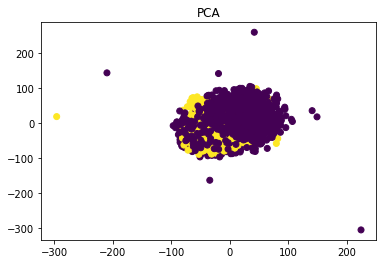

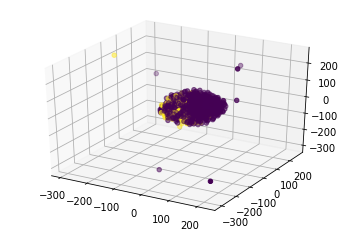

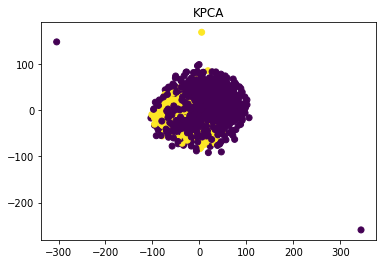

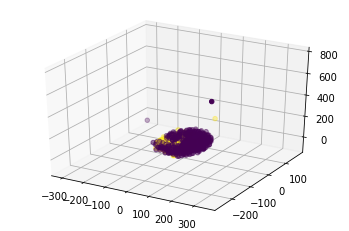

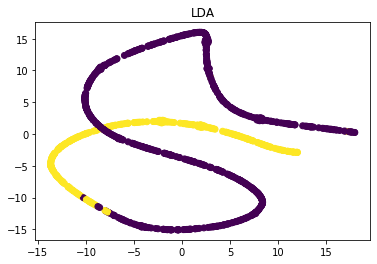

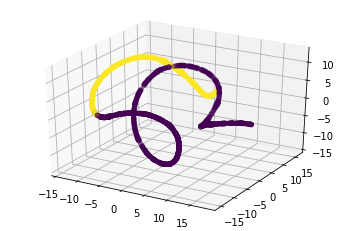

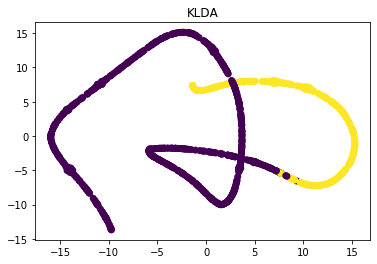

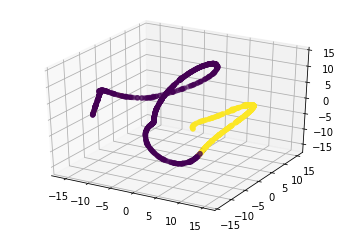

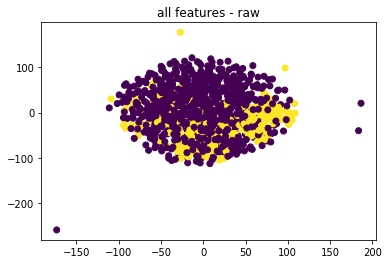

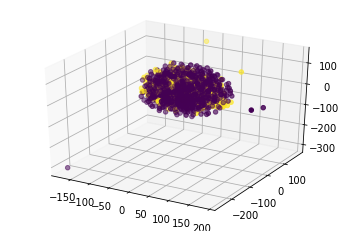

In [762]:
#Isomaps for all features

legend = ["PCA", "KPCA","LDA","KLDA","all features - raw"]
def showtsne(Xlist,y):
    k = 3 # Number of components in TSNE
    for i in range(len(Xlist)):
        # Compute
        tsne = TSNE(n_components=k).fit_transform(Xlist[i])

        # Plot the representation in 2d/3d
#         plt.scatter(*zip(*tsne[:,:2]), c=Xlist[i][:,2], cmap='RdBu')
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(tsne[:,0],tsne[:,1],c=y)
        plt.title(str(legend[i]))
        plt.show()

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
#         ax.scatter(*zip(*tsne), c=Xlist[i][:,2], cmap='RdBu')
        ax.scatter(tsne[:,0],tsne[:,1],tsne[:,2],c=y)     
        plt.show()
        
a,_ = get_pca(X,pca_ev)
b,_ = get_kernel_pca(X,kpca_ev)
c,_ = get_lda(X,y,lda_ev)
d,_ = get_kernel_lda(X,y,klda_ev)
g = X

Xlist = [a,b,c,d,g] 
showtsne(Xlist,y)

In [763]:
# Show quantitative results such as examples of correct prediction and wrong prediction
# kpca with Dtree
X_kpca,_ = get_kernel_pca(X,kpca_ev) 

#accuracy
X_train, X_test, y_train, y_test = train_test_split(X_kpca, y, test_size=0.2)
Tree_clf = tree.DecisionTreeClassifier()
Tree_clf.fit(X_train, y_train)
pred = Tree_clf.predict(X_test)
acc = Tree_clf.score(X_test, y_test)
print ("accuracy with KLDA and Decision tree: ",acc)

wrong_id = []
for i in range(len(pred)):
    if pred[i] != y_test[i]:
#         print (str(i) + " was wrongly classified.")
        wrong_id.append(i)
        

wrong_id = np.array(wrong_id)
print(wrong_id)

X_img = X.reshape((N1+N2,H,W,C))
# print("\nWrongly classified\n")
# disply_images(X_img[wrong_id,...],y[wrong_id],row=1,col=1)

# ind = np.random.randint(0,y.shape[0],1)
# disply_images(X[ind,...],y[ind], row=2,col=3)

# print("\n Correctly classified\n")
# disply_images(X_img[[18]],y[[18]],row=1,col=1)


accuracy with KLDA and Decision tree:  0.7581395348837209
[ 10  12  16  19  21  23  25  27  28  37  43  45  50  51  53  55  59  65
  66  68  80  82  84  86  87  89  90  99 106 107 109 118 121 127 129 130
 133 136 139 149 153 154 158 162 169 175 192 195 196 202 205 207]
